Import Libraries


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import zipfile
import matplotlib.pyplot as plt
import os


Load Dataset

In [2]:
# Download and extract dataset
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset_path = tf.keras.utils.get_file("cats_and_dogs_filtered.zip",
                                       origin=url,
                                       extract=True)

# Path to the extracted dataset
base_dir = os.path.join(os.path.dirname(dataset_path), "cats_and_dogs_filtered")

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

print("✅ Dataset downloaded and extracted!")
print("Training directory:", train_dir)
print("Validation directory:", validation_dir)


68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Dataset downloaded and extracted!
Training directory: /root/.keras/datasets/cats_and_dogs_filtered/train
Validation directory: /root/.keras/datasets/cats_and_dogs_filtered/validation


In [3]:
dataset_path = tf.keras.utils.get_file("cats_and_dogs_filtered.zip",
                                       origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip")

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(dataset_path))


base_dir = os.path.join(os.path.dirname(dataset_path), "cats_and_dogs_filtered")


train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

print("Train folder exists? ", os.path.exists(train_dir))
print("Validation folder exists? ", os.path.exists(validation_dir))


Train folder exists?  True
Validation folder exists?  True


Preprocess & Augment Data

In [4]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalize pixel values (0-1)
    rotation_range=40,       # rotate images up to 40 degrees
    width_shift_range=0.2,   # shift width by 20%
    height_shift_range=0.2,  # shift height by 20%
    shear_range=0.2,         # shear transformation
    zoom_range=0.2,          # zoom in/out
    horizontal_flip=True,    # flip horizontally
    fill_mode='nearest'      # fill in new pixels
)

# Only rescale validation data (no augmentation!)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # resize all images to 150x150
    batch_size=32,
    class_mode='binary'      # since cats vs dogs → binary classification
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Build CNN model

In [5]:
model = models.Sequential([
    # --- Feature Extraction ---
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # --- Classification ---
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')   # Binary classification (cat vs dog)
])

# Model Summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


Train the model

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
    )


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5068 - loss: 0.9045 - val_accuracy: 0.4990 - val_loss: 0.6884
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.5133 - loss: 0.6926 - val_accuracy: 0.5150 - val_loss: 0.6878
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.5257 - loss: 0.6911 - val_accuracy: 0.5130 - val_loss: 0.7207
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5284 - loss: 0.6802 - val_accuracy: 0.5670 - val_loss: 0.6771
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.5679 - loss: 0.6750 - val_accuracy: 0.5460 - val_loss: 0.6526
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6112 - loss: 0.6479 - val_accuracy: 0.6380 - val_loss: 0.6311
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6105 - loss: 0.6462 - val_accuracy: 0.6310 - val_loss: 0.6616
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.6226 - loss: 0.6539 - val_accuracy: 0.6790 - v

Evaluate the Model



In [8]:
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 465ms/step - accuracy: 0.7002 - loss: 0.5753
Validation Loss: 0.5510
Validation Accuracy: 0.7130


Plot Training Curves

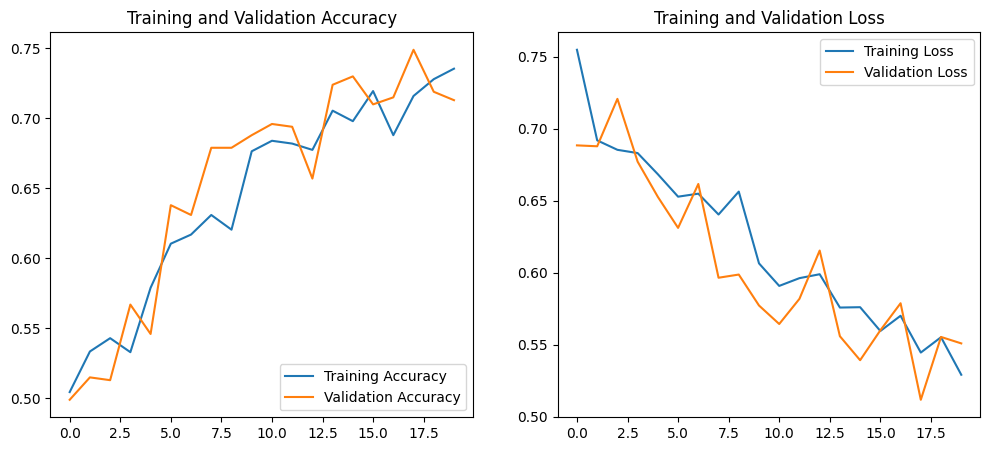

In [9]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


Make Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


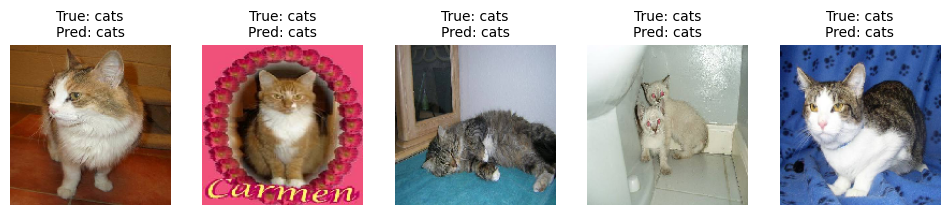

In [10]:
# Get one batch of validation data
val_images, val_labels = next(validation_generator)

# Predict on the batch
predictions = model.predict(val_images[:5])

# Convert probabilities to class labels (0=cat, 1=dog)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Class names mapping
class_names = list(validation_generator.class_indices.keys())

# Plot first 5 images with predictions
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(val_images[i])
    plt.axis("off")
    true_label = class_names[int(val_labels[i])]
    pred_label = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

plt.show()


Deliverables


In this project, we built a CNN to classify cats and dogs. First, we imported TensorFlow, Keras, and Matplotlib. Then, we downloaded and extracted the dataset containing training and validation images. Using ImageDataGenerator, we rescaled pixel values (0–1) and applied data augmentation (rotation, shift, zoom, flip) to improve generalization. We built a CNN with convolution and pooling layers for feature extraction, followed by dense layers for classification. The model was compiled with Adam optimizer and binary crossentropy loss. After training for 20 epochs, we evaluated accuracy, plotted training curves, and visualized predictions on sample validation images.